In [1]:
#import dependencies
import math
from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


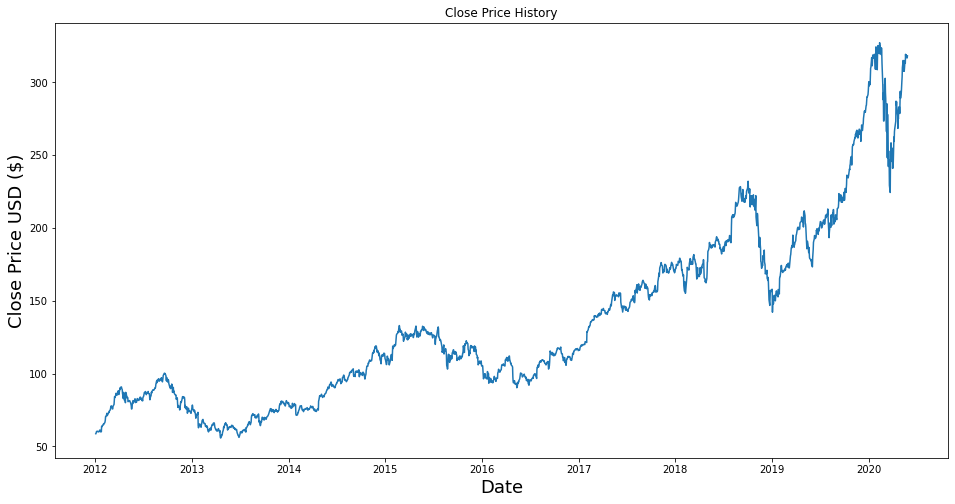

In [2]:
#fetch historical data
dateToday = datetime.today().strftime('%Y-%m-%d')
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-05-27')

#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [3]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [4]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [5]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1631/1631 [==============================] - 87s 53ms/step - loss: 5.9170e-04


In [6]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [7]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-05-27')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[294.4202]]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


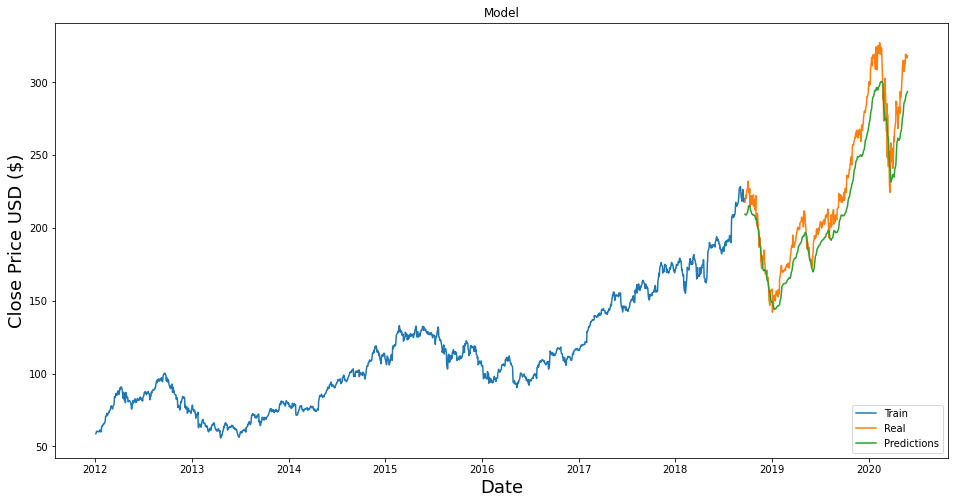

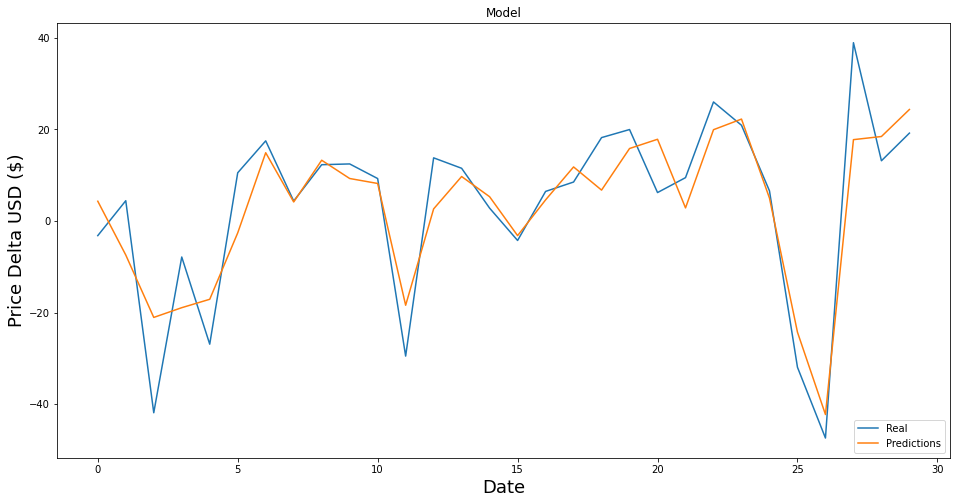

90.00% accuracy for a duration of 14 day(s)


In [55]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Real', 'Predictions'], loc='lower right')
plt.show()

realDelta = []
predictedDelta = []
signMatch = []

#for i in range(len(valid) - 1):
#    realDelta.append((valid['Close'][i + 1] - valid['Close'][i]))
#    predictedDelta.append(valid['Predictions'][i + 1] - valid['Predictions'][i])

# Calculate change in values over a given duration
duration = 14
i = 0;
while i < (len(valid) - duration):
    realDelta.append((valid['Close'][i + duration] - valid['Close'][i]))
    predictedDelta.append(valid['Predictions'][i + duration] - valid['Predictions'][i])
    if realDelta[-1] * predictedDelta[-1] >= 0:
        signMatch.append(True)
    else:
        signMatch.append(False)
    i+=duration
    
# Plot value deltas
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price Delta USD ($)', fontsize=18)
plt.plot(realDelta)
plt.plot(predictedDelta)
plt.legend(['Real', 'Predictions'], loc='lower right')
plt.show()

# Calculate the accuracy of the deltas
accuracy = (signMatch.count(True)/len(signMatch))*100
print("{:.2f}".format(accuracy) + '% accuracy for a duration of ' + str(duration) + ' day(s)')

In [11]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-05-27')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get the last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append the past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[294.4202]]


In [12]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start=dateToday, end=dateToday)
print(apple_quote2['Close'])

Date
2020-05-28    318.25
Name: Close, dtype: float64
